# Data processing

In [1]:
## PREAMBLE ##

libraries = c("rootSolve","deSolve","dplyr","magrittr","tidyr","ggplot2","nimble","rriskDistributions","readxl","knitr",
              "zoo","gridExtra","RColorBrewer")
for(x in libraries) {
    library(x,character.only=TRUE,warn.conflicts=FALSE) }

base_sz = 11 # base_size parameter

# options(jupyter.plot_mimetypes = "image/svg+xml") 
clrs = brewer.pal(8,"Set1")

'%&%' <- function(x,y)paste0(x,y)
    
# Initialization of array for recorded plots
plot_point_sizes <- c(); nm <- c(); plot_point_sizes <- list()

nimble version 0.6-12 is loaded.
For more information on NIMBLE and a User Manual,
please visit http://R-nimble.org.


# I. Processing the data

## Importing the data from Excel file

### Categories of the data

We use the following categorization for our data:
* **Timeseries** = different parts of data that are separetely used for the further analysis 
* **Year** = year under record
* **Week** = the number of epi week
* **LGAs** = number of LGAs affected by the epidemic (presumably for Nigeria)
* **States** = number of states affected by the epidemic
* **Reported** = Reported cases
* **Deaths** = Reported (suspected + confirmed) death cases
* **Confirmed** = Lab-confirmed cases
* **Imputation** = 1 when the data point was imputed by using spline interpolation (see the corresponing Jupyter notebook for details), 0 otherwise
* **Source** = source of information

In [2]:
data_file = "../data/Nigeria_raw.xlsx"
read_excel(data_file,sheet="Incidence") %>%
    select(c("Timeseries","Year","Week","LGAs","States","Reported","Deaths","Confirmed")) -> data #-one_of("Source","Imputation")
data %>% head(10)

Timeseries,Year,Week,LGAs,States,Reported,Deaths,Confirmed
1,2018,30,NA,NA,926,68,225
1,2018,29,NA,NA,910,68,220
1,2018,28,NA,NA,877,65,214
1,2018,27,141,29,862,64,209
1,2018,26,141,29,842,62,204
1,2018,25,141,29,830,62,202
1,2018,24,141,29,806,60,196
1,2018,23,141,29,800,60,195
1,2018,22,141,29,796,60,194
1,2018,21,137,29,791,60,193


Range of years under consideration

In [3]:
yearMin = 2012; yearMax = 2018 
#define which years b/w yearMin and yearMax we have in our dataset
data$Year %>% unique %>% na.omit %>% .[order(.)] %>% .[yearMin<=.&.<=yearMax] -> yrs   
yrs

[1] 2012 2013 2014 2015 2016 2017 2018

Function to get the list of Fridays for a given year

In [4]:
getFridays = function(year,is_the_first_weekday_Monday=TRUE) {
    starting_date = if_else((as.POSIXlt((year-1)%&%'-12-31')$wday-is_the_first_weekday_Monday)%%7<3,
                            as.Date(year%&%'-01-01'),as.Date(year%&%'-01-06'))
    finishing_date = if_else((as.POSIXlt(year%&%'-12-31')$wday-is_the_first_weekday_Monday)%%7<3,
                            as.Date(year%&%'-12-31'),as.Date((year+1)%&%'-01-04'))
    return(seq(starting_date,finishing_date,'days')%>%.[weekdays(.)=='Friday']) }

In [5]:
as.data.frame(yrs) %>% rowwise() %>% mutate("Number of weeks"=length(getFridays(yrs)))

yrs,Number of weeks
2012,52
2013,52
2014,52
2015,53
2016,52
2017,52
2018,51


In [6]:
data %>% 
    filter(!is.na(Year)&!is.na(Week)&(yearMin<=Year)&(Year<=yearMax)) %>% 
    group_by(Year) %>% 
    filter(Week==max(Week)) %>%
    arrange(Year) %>% 
    ungroup %>%
    mutate(Reported=cumsum(Reported),
           Deaths=cumsum(Deaths),
           Confirmed=cumsum(Confirmed)) -> df0
df0

Timeseries,Year,Week,LGAs,States,Reported,Deaths,Confirmed
2,2012,52,42,23,1728,112,201
2,2013,52,NA,NA,2907,151,362
NA,2014,52,37,13,3896,187,472
1,2015,53,37,15,4326,227,497
1,2016,52,144,29,5247,346,608
1,2017,52,95,29,5980,417,751
1,2018,30,NA,NA,6906,485,976


In [7]:
# number of missed records in omitted part of the data
data %>% filter(is.na(Timeseries)==T&is.na(Reported)==T) %>% nrow

[1] 94

In [8]:
# number of present records in omitted part of the data
data %>% filter(is.na(Timeseries)==T&is.na(Reported)==F) %>% nrow

[1] 22

In [9]:
# total number of data points
(total_date = data %>% filter(is.na(Timeseries)==F) %>% nrow)

[1] 286

In [10]:
# number of data points obtained by linear regression
(total_interpolated = data %>% filter(is.na(Timeseries)==F&is.na(Reported)==T) %>% nrow)

[1] 7

In [11]:
total_interpolated/total_date*100.

[1] 2.447552

In [12]:
data %>%
    filter(!is.na(Year)&!is.na(Week)&(yearMin<=Year)&(Year<=yearMax)) %>%
    rowwise() %>%
    mutate(Reported=Reported+if_else(Year>yearMin,as.numeric(df0[which(df0['Year']==Year-1),'Reported']),0),
          Deaths=Deaths+if_else(Year>yearMin,as.numeric(df0[which(df0['Year']==Year-1),'Deaths']),0),
          Confirmed=Confirmed+if_else(Year>yearMin,as.numeric(df0[which(df0['Year']==Year-1),'Confirmed']),0),
          Date=getFridays(Year)[Week]) %>%
    arrange(Year,Week) -> df.wide
df.wide %>% tail

Timeseries,Year,Week,LGAs,States,Reported,Deaths,Confirmed,Date
1,2018,25,141,29,6810,479,953,2018-06-29
1,2018,26,141,29,6822,479,955,2018-07-06
1,2018,27,141,29,6842,481,960,2018-07-13
1,2018,28,NA,NA,6857,482,965,2018-07-20
1,2018,29,NA,NA,6890,485,971,2018-07-27
1,2018,30,NA,NA,6906,485,976,2018-08-03


To check whether all weeks are present in the data

In [13]:
Calendar = c()
for(yr in yrs) 
    Calendar %<>% 
        rbind(as.data.frame(list(Date=NA,Year=yr,Week=1:length(getFridays(yr))))) %>%
        rowwise() %>% 
        mutate(Date=getFridays(Year)[Week]) %>%
        filter((Date>=min(df.wide$Date))&(Date<=max(df.wide$Date)))
if(nrow(Calendar)!=nrow(df.wide)) {
    message("[-] Some weeks are absent in the data!") 
} else {
    message("[+] All weeks are present in the data") }
tail(Calendar)

[+] All weeks are present in the data


Date,Year,Week
2018-06-29,2018,25
2018-07-06,2018,26
2018-07-13,2018,27
2018-07-20,2018,28
2018-07-27,2018,29
2018-08-03,2018,30


In [14]:
write.table(Calendar,"../data/Calendar.csv",row.names=F,sep=",")

# III. Classifying the dataset

Different types of factors

In [15]:
Cases = c("Reported","Deaths","Confirmed")
Coverage = c("LGAs","States")

Transforming the dataframe to the long form

In [16]:
df.wide %>% 
    gather(Category,Count,-Date,-Year,-Week,-Timeseries) %>%
    mutate(Category=factor(Category,levels=c(Cases,Coverage))) -> df
tail(df)

Timeseries,Year,Week,Date,Category,Count
1,2018,25,2018-06-29,Confirmed,953
1,2018,26,2018-07-06,Confirmed,955
1,2018,27,2018-07-13,Confirmed,960
1,2018,28,2018-07-20,Confirmed,965
1,2018,29,2018-07-27,Confirmed,971
1,2018,30,2018-08-03,Confirmed,976


In [17]:
# df.wide %>% select(Date) %>%
#     right_join(df) -> df
# df %>% tail

Warning message:
“Removed 287 rows containing missing values (geom_point).”

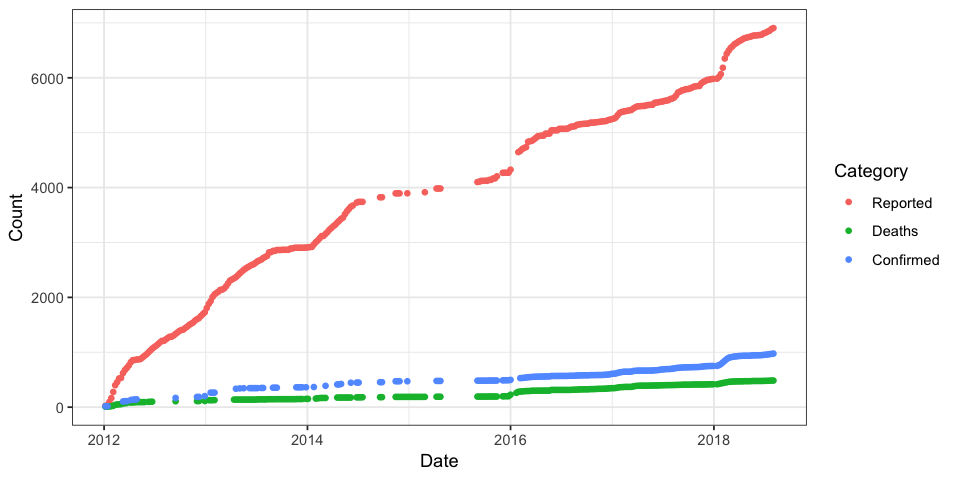

In [18]:
options(repr.plot.width=8,repr.plot.height=4)
df %>% 
    filter(Category %in% Cases) %>%
    ggplot(group=Category) +
        geom_point(aes(x=Date, y=Count, colour=Category), size=1.2) + 
        theme_bw()

Warning message:
“Removed 206 rows containing missing values (geom_point).”

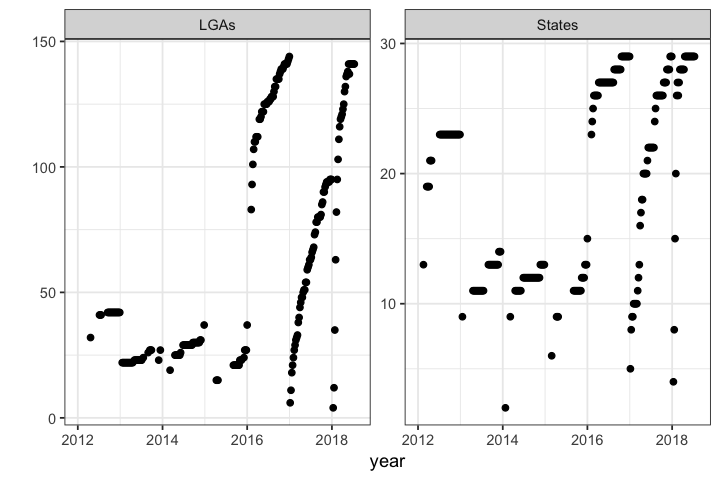

In [19]:
curr_size = c(6,4)
options(repr.plot.width=curr_size[1],repr.plot.height=curr_size[2])
figNo = 1; nm[figNo] = "LGAs_and_States"; plot_point_sizes[[figNo]] = curr_size
par(mar=c(4,4.5,1.5,2)+.1)

df %>%
    filter(Category %in% Coverage) %>%
    ggplot(group=Category) + facet_wrap(~ Category,scales="free_y") +
        geom_point(aes(x=Date, y=Count), size=1.5) + 
        scale_size_area() + xlab("year") + ylab(" ") + theme_bw()

assign(nm[figNo],recordPlot())

Transforming the dataframe for the following figure

In [20]:
df.wide %>%
    group_by(Timeseries) %>%
    mutate(Reported = spline(x=Date,y=Reported,xout=Date)$y,
          Confirmed = spline(x=Date,y=Confirmed,xout=Date)$y,
          Deaths = spline(x=Date,y=Deaths,xout=Date)$y) %>%
    select(-LGAs,-States) %>%
    mutate_each(funs(round(as.numeric(.))), -one_of("Year","Week","Date")) %>%
    #Transforming to the long form
    gather(Category,Count,-Date,-Year,-Week,-Timeseries) %>%
    mutate(Category=factor(Category,levels=Cases)) -> df1
df1 %>% head

`mutate_each()` is deprecated.
Use `mutate_all()`, `mutate_at()` or `mutate_if()` instead.
To map `funs` over a selection of variables, use `mutate_at()`


Timeseries,Year,Week,Date,Category,Count
2,2012,1,2012-01-06,Reported,26
2,2012,2,2012-01-13,Reported,27
2,2012,3,2012-01-20,Reported,96
2,2012,4,2012-01-27,Reported,166
2,2012,5,2012-02-03,Reported,277
2,2012,6,2012-02-10,Reported,400


Warning message:
“Removed 287 rows containing missing values (geom_point).”

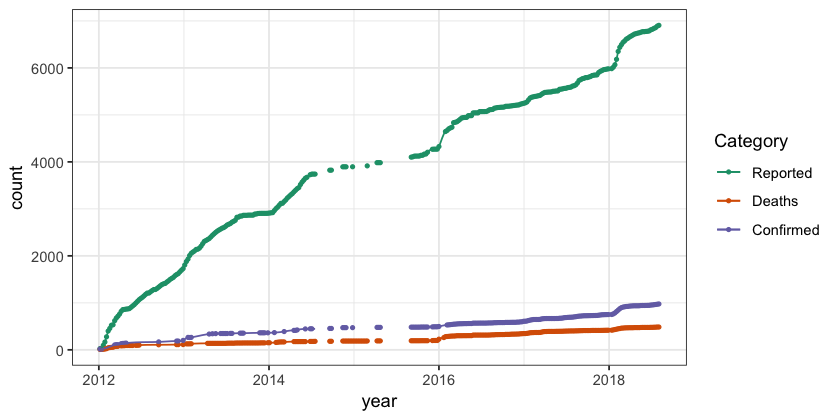

In [21]:
curr_size = c(7,3.5)
options(repr.plot.width=curr_size[1],repr.plot.height=curr_size[2])
par(mar=c(4,4.5,1.5,2)+.1)

number_ticks <- function(n) {function(limits) pretty(limits, n)}
                             
df1 %>%
    filter(Category %in% Cases) %>%
    ggplot() + 
        geom_point(data=filter(df,Category %in% Cases),aes(x=Date,y=Count,colour=Category),size=.8,alpha=1) +
        scale_size_area() + xlab("year") + ylab("count") + 
        scale_color_brewer(palette="Dark2") + 
        theme_bw() -> gplt

df1 %>% 
    filter(Category %in% Cases) %>%
    na.omit %>%
    group_by(Timeseries) %>%
    do(
        x = geom_path(data=.,aes(x=Date,y=Count,colour=Category),lty=1)
    ) -> df1_plots
                                
gplt+df1_plots$x[[1]]+df1_plots$x[[2]]

Calculating weekly incidence

In [22]:
df1 %>%
    group_by(Timeseries,Category) %>%
    mutate(Incidence = Count-lag(Count),  # remember that all weeks are accounted
          Incidence = replace(Incidence, is.na(Incidence), 0)) %>% ungroup -> dfIncidence

# Transforming the dataframe to the wide form for our convenience
dfIncidence %<>%
    na.omit %>%
    unite(Count_Incidence,Count,Incidence,sep="_") %>%
    spread(Category,Count_Incidence) %>%
    separate(Reported,c("Reported.Count","Reported.Incidence"),sep="_") %>%
    separate(Deaths,c("Deaths.Count","Deaths.Incidence"),sep="_") %>%
    separate(Confirmed,c("Confirmed.Count","Confirmed.Incidence"),sep="_") %>%
    mutate_each(funs(round(as.numeric(.))), -(1:4)) %>%
    mutate(Index=1:n())

head(dfIncidence)

`mutate_each()` is deprecated.
Use `mutate_all()`, `mutate_at()` or `mutate_if()` instead.
To map `funs` over a selection of variables, use `mutate_at()`


Timeseries,Year,Week,Date,Reported.Count,Reported.Incidence,Deaths.Count,Deaths.Incidence,Confirmed.Count,Confirmed.Incidence,Index
1,2015,35,2015-08-28,4128,0,193,0,483,0,1
1,2015,36,2015-09-04,4101,-27,193,0,483,0,2
1,2015,37,2015-09-11,4108,7,193,0,483,0,3
1,2015,38,2015-09-18,4123,15,193,0,483,0,4
1,2015,39,2015-09-25,4123,0,193,0,483,0,5
1,2015,40,2015-10-02,4124,1,193,0,483,0,6


# IV. Weekly incidence rate, death rate and convolution operator

In [23]:
dfIncidence %>%
    select(Timeseries,Date,Week,Year,Reported.Incidence,Deaths.Incidence) %>%
    rename(Incidence=Reported.Incidence,Deaths=Deaths.Incidence) %>% rowwise %>%
    mutate(Incidence = if_else(Incidence<0,0,Incidence)) %>% ungroup -> df_
df_ %>% head

Timeseries,Date,Week,Year,Incidence,Deaths
1,2015-08-28,35,2015,0,0
1,2015-09-04,36,2015,0,0
1,2015-09-11,37,2015,7,0
1,2015-09-18,38,2015,15,0
1,2015-09-25,39,2015,0,0
1,2015-10-02,40,2015,1,0


`geom_smooth()` using method = 'loess' and formula 'y ~ x'


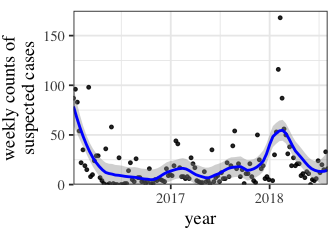

In [25]:
curr_size = c(2.75,2)
options(repr.plot.width=curr_size[1],repr.plot.height=curr_size[2])
figNo = 2; nm[figNo] = "Incidence_rates"; plot_point_sizes[[figNo]] = curr_size

pt_sz = .7


df_ %>% arrange(Date) %>%
    filter(Year>=2016) %>%
    select(Date,Incidence) %>% 
    ggplot(group=Category,aes(x=Date,y=Incidence)) +
        geom_point(size=pt_sz,alpha=.85) + 
        geom_smooth(span=.3,color="blue",size=.8,fullrange=TRUE) +
        xlab("year") + ylab("weekly counts of\nsuspected cases") + 
        scale_x_date(date_breaks = "1 year", date_labels = "%Y") +
        theme_bw(base_size=base_sz,base_family='Times') + 
        coord_cartesian(expand=0, ylim = c(0, 175)) +
        theme(plot.margin=unit(c(.45,.1,.5,.1),"lines"))

assign(nm[figNo],recordPlot())

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


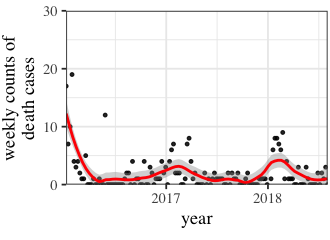

In [26]:
options(repr.plot.width=curr_size[1],repr.plot.height=curr_size[2])
figNo = 3; nm[figNo] = "Death_rates"; plot_point_sizes[[figNo]] = curr_size

df_ %>% arrange(Date) %>%
    filter(Year>=2016) %>%
    select(Date,Deaths) %>% 
    ggplot(group=Category,aes(x=Date,y=Deaths)) +
        geom_point(size=pt_sz,alpha=.85) + 
        geom_smooth(span=.3,color="red",size=.8,fullrange=TRUE) +
        xlab("year") + 
        ylab("weekly counts of\ndeath cases") + 
        scale_x_date(date_breaks = "1 year", date_labels = "%Y") +
        theme_bw(base_size=base_sz,base_family='Times') + 
        coord_cartesian(expand=0, ylim = c(0, 30)) +
        theme(plot.margin=unit(c(.45,.1,.5,.1),"lines")) 

assign(nm[figNo],recordPlot())

In [27]:
df_ %>% filter(Deaths<0)

Timeseries,Date,Week,Year,Incidence,Deaths
2,2012-12-14,50,2012,38,-1
2,2012-12-21,51,2012,35,-1
2,2013-08-02,31,2013,18,-1


In [28]:
df_ %<>% mutate(Deaths = ifelse(Deaths<0,0,Deaths))

# Saving the recorded plots

In [30]:
print(paste("Number of recorded plots: ",length(plot_point_sizes),sep=""))
for (k in 1:length(plot_point_sizes)) {
    filename = paste("../figures/draft/",nm[k],".pdf",sep="")
    print(paste("(",k,") ",filename,sep=""))
    cs = plot_point_sizes[[k]]
    pdf(filename,width=cs[1],height=cs[2]);
    replayPlot(eval(as.name(nm[k])));
    dev.off() }

[1] "Number of recorded plots: 3"
[1] "(1) ../figures/draft/LGAs_and_States.pdf"
[1] "(2) ../figures/draft/Incidence_rates.pdf"
[1] "(3) ../figures/draft/Death_rates.pdf"
